## Interaktive Karte um AOI einzuzeichnen

In [1]:
from ipyleaflet import Map, DrawControl
import numpy as np

# Ausgabe der Bounding Box der letzten gezeichneten Geometrie
def get_bounding_box():
    drawn_coordinates = draw_control.data[-1]['geometry']['coordinates']

    min_lat = None
    max_lat = None

    min_lon = None
    max_lon = None

    for coords in drawn_coordinates[0]:
        if max_lat is None:
            max_lat =  min_lat = np.round(coords[1], 2)
            max_lon =  min_lon = np.round(coords[0], 2)

        elif coords[1] < min_lat:
            min_lat = np.round(coords[1], 2)

        elif coords[1] > max_lat:
            max_lat = np.round(coords[1], 2)

        elif coords[0] < min_lon:
            min_lon = np.round(coords[0], 2)

        elif coords[0] > max_lon:
            max_lon = np.round(coords[0], 2)

    return [min_lat, max_lat], [min_lon, max_lon]


m = Map(center=(50, 3), zoom=2)

draw_control = DrawControl()

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m

ModuleNotFoundError: No module named 'ipyleaflet'

## Prüfe ob AOI gezeichnet

In [20]:
try:
    LAT_BOUNDING_BOX, LON_BOUNDING_BOX = get_bounding_box()
    print(LAT_BOUNDING_BOX)
    print(LON_BOUNDING_BOX)

except IndexError:
    print("Bitte Area of Interest in Karte einzeichnen!")



[23.89, 43.33]
[46.76, 73.12]


## Importe und Definitionen

In [21]:
import os

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

from datetime import datetime as dt

import xarray as xr
import calendar

LAT_BOUNDING_BOX = [5.97, 29.23]
LON_BOUNDING_BOX = [67.15, 88.95]

# Umrechnen des Monatsdurchschnitts von mm / hr in Monatssumme mm / month:
def accumulate_precip(data, timestamp):
    real_timestamp = dt.utcfromtimestamp(timestamp).strftime('%Y-%m-%d').split("-")

    # mm / d:
    data = data * 24

    # mm / month: Fallunterscheidung nötig für unterschiedlich lange Monate & Schaltjahre
    if real_timestamp[1] in ["01", "03", "05", "07", "08", "10", "12"]:
        data *= 31
        print("long month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp[1] == "02" and calendar.isleap(int(real_timestamp[0])):
        data *= 29
        print("short month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp == "02" and not calendar.isleap(int(real_timestamp[0])):
        data *= 28
        print("very short month") # min:  ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    else:
        data *= 30
        print("medium month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))
    
    return data


# Liest Werte des AOI aus HDF5-Datei aus und gibt ein xarray monatlich akkumulierter Werte zurück
def xr_aoi(FILE_NAME, LAT_RANGE, LON_RANGE):
        
    with h5py.File(FILE_NAME, mode='r') as f:
        # Einlesen der Breitenkoordinaten
        lat = f['Grid/lat'][ : ]
        #print(lat)

        # Einlesen der Längenkoordinaten
        lon = f['Grid/lon'][ : ]
        #print(lon)

        # Zeitstempel vom ersten Tag des Monats in Unix-Zeit
        unix_timestamp = f['Grid/time'][0]
        # Umrechnung in UTC-Zeit
        utc_timestamp = dt.utcfromtimestamp(unix_timestamp) #.strftime('%Y-%m-%d')    

        # Einlesen der Niederschlagsdaten: gegeben in mm / hr
        data = f['Grid/precipitation'][0,:,:]

        # Einlesen des Füllwertes aus den Attributen
        _FillValue = f['Grid/precipitation'].attrs['_FillValue']


        # Ersetzen des Füllwertes durch nan
        data[data == _FillValue] = np.nan
        
        # Umrechnen von mm / hr in Monatssumme
        data = accumulate_precip(data, unix_timestamp)

        #units = f[name].attrs['units']


        # Zuweisung von Koordinatenskalen für neues xarray
        coords =  {
            'lon': lon,
            'lat': lat,  
            'time': utc_timestamp
            }
        
        # Definition von zusätzlichen Attributen
        attrs = {
            'fill_value': _FillValue
        }

        # Anlegen des xarrays mit allen NS-Daten und obigen Definitionen
        da = xr.DataArray(
            data, 
            coords=coords, 
            dims=['lon', 'lat'],
            attrs=attrs
            )
        #print(da)

        # Extraktion der Werte für AOI
        da_sel = da.sel({
                'lon': LON_RANGE,
                'lat': LAT_RANGE                
                },
                method='nearest',
                tolerance=0.09
                )
        
        print(da_sel.coords)
        print("min: ", np.nanmin(da_sel.values), ", max: ", np.nanmax(da_sel.values), ", mean: ", np.nanmean(da_sel.values))

        return da_sel

# Plottet die Werte eines xarrays
def plot_aoi(data, title_str="DEFAULT TITLE", axis_label="DEFAULT LABEL"):
    # Es soll ein Rahmen um das AOI von 8° in alle Richtungen geplottet werden
    try:
        m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]-8), urcrnrlat=(LAT_BOUNDING[1]+8),
                llcrnrlon=(LON_BOUNDING[0]-8), urcrnrlon=(LON_BOUNDING[1]+8)
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    # Liegt einer der Werte außerhalb des Werteraums [-90;90] bzw. [-180;180] wird kein Rahmen geplottet
    except ValueError:
                m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]), urcrnrlat=(LAT_BOUNDING[1]),
                llcrnrlon=(LON_BOUNDING[0]), urcrnrlon=(LON_BOUNDING[1])
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.2)
    m.drawparallels(np.arange(
        (LAT_BOUNDING[0]) - 15, 
        (LAT_BOUNDING[1] + 15), 
        ( (LAT_BOUNDING[1] - LAT_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.drawmeridians(
        np.arange(
        (LON_BOUNDING[0]) - 15, 
        (LON_BOUNDING[1] + 15), 
        ( (LON_BOUNDING[1] - LON_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.pcolormesh(
        LON_RANGE,
        LAT_RANGE,
        data.T,
        latlon=True
        )
    cb = m.colorbar()    
    cb.set_label(axis_label)

    plt.title(f'{title_str} {str(data.time.values)[0:7]}') # Abschneiden des restlichen Zeitstempels
 


## Lesen der Datei aus Ordner, Zusammenführen in xarray-Zeitreihe

In [22]:
DATA_PATH = '../data/GPM_Data_2000_2021'
#DATA_PATH = './data/GPM_Data_Small'

LAT_BOUNDING = sorted(LAT_BOUNDING_BOX)
LON_BOUNDING = sorted(LON_BOUNDING_BOX)

# Anlegen von Arrays mit Größe der Bounding Box & passender Auflösung
LAT_RANGE = np.arange(LAT_BOUNDING[0], LAT_BOUNDING[1], 0.1)
LON_RANGE = np.arange(LON_BOUNDING[0], LON_BOUNDING[1], 0.1)

# Liste um die xarray-Monatsniederschläge temporär zu speichern
data_array_list = []

# Sortieren der Dateinamen: alt nach neu
filepaths = sorted(os.listdir(DATA_PATH))


for filename in filepaths:
    # Überspringe alle nicht-HDF5 Dateien
    if filename[-4:] != 'HDF5': 
        print(f'Unpassendes Dateiformat:\n"{filename}"\nUeberspringe Datei')
        continue

    # Zusammmensetzen von Speicherpfad und Dateiname
    path_file = os.sep.join([DATA_PATH, filename])

    # Anfügen der akkumulierten Monatsniederschläge für das AOI an temporäre Liste
    data_array_list.append(xr_aoi(path_file, LAT_RANGE, LON_RANGE))

# Stack der Monatsniederschläge entlang der Zeitachse für eine Zeitreihe
xr_data_stack = xr.concat(data_array_list, 'time' )


medium month
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28.95 29.05 29.15
    time     datetime64[ns] 2000-06-01
min:  9.7244745e-05 , max:  1477.0717 , mean:  217.0327
long month
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28.95 29.05 29.15
    time     datetime64[ns] 2000-07-01
min:  0.29798394 , max:  1700.6936 , mean:  222.98299
long month
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28.95 29.05 29.15
    time     datetime64[ns] 2000-08-01
min:  3.7950594 , max:  1314.8751 , mean:  231.03987
medium month
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28

## Gruppieren des Zeitreihen-Stacks nach Monaten

In [23]:
# Gruppieren der Monate 1-12 --> Index startet bei 1!
grouped_stacks = xr_data_stack.groupby(xr_data_stack.time.dt.month) 
#grouped_stacks[6][-1] # letztes Jahr des Monats Juni

## Berechnen der % des durchschnittlichen Niederschlags pro Zelle, Monat und Jahr

In [24]:
# 2D Liste für xarrays mit den Zellwerten des Percent of Normal Index (PNI)
percent_of_average_precip_stack = [ [] for _ in range(12) ]

# Iteriere über die stacks der 12 Monate
for i, month in enumerate(grouped_stacks):

    # "month" als Teil des groupedby-Objekts "grouped_stacks" ist ein Tupel, 
    # xarray ist an Stelle 1, 
    # Durchschnitt entlang der Zeitachse, 
    # "skipna" überspringt nan-Werte
    average_over_time = month[1].mean(dim="time", skipna=True)

    # Iteriere über die Jahrgänge innerhalb der verschiedenen Monate 
    # und berechne jeweils die Höhe gemessen am langjährigen Mittel
    for j, month_of_year in enumerate(month[1]):
        percent_of_average_precip_stack[i].append((month_of_year / average_over_time ) * 100) # = PNI je Zelle!


# Iteriere über die 12 Monate, "stack" jeweils als Liste von xarrays der Jahrgänge mit den Zellwerten des PNI
for i, stack in enumerate(percent_of_average_precip_stack):
    print("Monat ", i+1)
    print("Datentyp: ", type(stack))
    print("Länge der Liste / Anzahl der Jahre: ",len(stack))


Monat  1
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  2
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  3
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  4
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  5
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  6
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  22
Monat  7
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  22
Monat  8
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  9
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  10
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  11
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21
Monat  12
Datentyp:  <class 'list'>
Länge der Liste / Anzahl der Jahre:  21


## Beispiel: Prozent des langjährigen Niederschlags je Zelle im Juli 2004

In [25]:
print(percent_of_average_precip_stack[6][4])

<xarray.DataArray (lon: 218, lat: 233)>
array([[189.97693 , 182.01051 , 154.46663 , ...,  12.522734,  17.266142,
         19.894789],
       [178.28513 , 175.50192 , 154.59793 , ...,  11.040516,  11.614658,
         23.655508],
       [186.27357 , 156.85701 , 121.10706 , ...,  10.616262,   9.158478,
         11.567139],
       ...,
       [189.74664 , 169.37776 , 150.44873 , ..., 141.23463 , 148.15349 ,
        151.79253 ],
       [162.65251 , 130.34619 , 125.561356, ..., 142.66936 , 151.56264 ,
        160.73279 ],
       [136.47752 , 116.57449 , 116.82776 , ..., 141.28001 , 145.27812 ,
        159.52335 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28.95 29.05 29.15
    time     datetime64[ns] 2004-07-01


## Abfrage des durchschnittlich trockensten Januars

In [26]:
# Summe der Prozente = 0
sum_percts = 0

# Iteriere über den Stack der % monatlichen Durchschnitts-NS für Januar ( idx = 0)
# und summiere über die 21 Jahre auf
for i, stack in enumerate(percent_of_average_precip_stack[0]):
    # Ausgabe des Durchschnitts aller Zellen EINES Jahres im AOI
    print( np.datetime_as_string(stack.time, 'M' ), ": ", np.nanmean(stack))
    sum_percts += np.nanmean(stack)

# Der Durchschnitt ergibt wiederum 100: passt!
print("Durchschnitt = 100?: ", sum_percts / 21)

# Mit folgender Abfrage ist es nun möglich auf das Minimum der Monate Januar zuzugreifen 
# und an das entsprechende Datum zu gelangen
minimum_of_jan = min( [ stack.mean(skipna=True) for stack in percent_of_average_precip_stack[0] ])
print("Minimalwert im Januar-Stack: ")
print(minimum_of_jan, '\n', np.datetime_as_string(minimum_of_jan.time, 'M'))


2001-01 :  62.079327
2002-01 :  118.75852
2003-01 :  82.43586
2004-01 :  124.413185
2005-01 :  152.85675
2006-01 :  53.659966
2007-01 :  35.437508
2008-01 :  74.15616
2009-01 :  49.193245
2010-01 :  116.15198
2011-01 :  71.095634
2012-01 :  90.45351
2013-01 :  79.05203
2014-01 :  175.5047
2015-01 :  158.36005
2016-01 :  58.396603
2017-01 :  99.0971
2018-01 :  52.613266
2019-01 :  66.747215
2020-01 :  128.72672
2021-01 :  250.81068
Durchschnitt = 100?:  100.0
Minimalwert im Januar-Stack: 
<xarray.DataArray ()>
array(35.437508, dtype=float32)
Coordinates:
    time     datetime64[ns] 2007-01-01 
 2007-01


## Abfrage der trockensten Jahre je Monat & des globalen Minimums

In [27]:
# Kandidat für globales Minimum
minimum_candidate = None

# Liste möglicher Kandidaten: mehrere Monate in Folge? Dann Favorit!
candidates_list = []

# Iteriere über alle Monate des PNI
for month in percent_of_average_precip_stack:
    # Setzen des ersten Kandidaten im ersten Durchlauf
    if minimum_candidate is None:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])

    # Prüfe für alle folgenden Durchläufe ob Wert unter bisherigem Kandidaten,  
    # falls ja: Update des Kandidaten
    elif min( [ stack.mean(skipna=True) for stack in month ]) < minimum_candidate:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])
    
    # Das Minimum des jeweiligen Monts wird der Liste angehängt
    candidates_list.append(min( [ stack.mean(skipna=True) for stack in month ]))

    print(min( [ stack.mean(skipna=True) for stack in month ]))

# Ausgabe des globalen Minimums
print("Globales Minimum: ", np.datetime_as_string(minimum_candidate.time, 'M'), '\n', minimum_candidate)

<xarray.DataArray ()>
array(35.437508, dtype=float32)
Coordinates:
    time     datetime64[ns] 2007-01-01
<xarray.DataArray ()>
array(14.930318, dtype=float32)
Coordinates:
    time     datetime64[ns] 2009-02-01
<xarray.DataArray ()>
array(27.98822, dtype=float32)
Coordinates:
    time     datetime64[ns] 2010-03-01
<xarray.DataArray ()>
array(23.510012, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-04-01
<xarray.DataArray ()>
array(36.939404, dtype=float32)
Coordinates:
    time     datetime64[ns] 2012-05-01
<xarray.DataArray ()>
array(56.686394, dtype=float32)
Coordinates:
    time     datetime64[ns] 2012-06-01
<xarray.DataArray ()>
array(43.03417, dtype=float32)
Coordinates:
    time     datetime64[ns] 2002-07-01
<xarray.DataArray ()>
array(59.887436, dtype=float32)
Coordinates:
    time     datetime64[ns] 2005-08-01
<xarray.DataArray ()>
array(51.95954, dtype=float32)
Coordinates:
    time     datetime64[ns] 2002-09-01
<xarray.DataArray ()>
array(58.67325, dtype=float

## Und die übrigen Monate?

In [28]:
# Sortieren der Monate nach Zeitstempel
candidates_list = sorted(candidates_list, key=lambda x: x.time)
candidates_list

[<xarray.DataArray ()>
 array(58.67325, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2000-10-01,
 <xarray.DataArray ()>
 array(43.03417, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2002-07-01,
 <xarray.DataArray ()>
 array(51.95954, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2002-09-01,
 <xarray.DataArray ()>
 array(33.296528, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2004-12-01,
 <xarray.DataArray ()>
 array(59.887436, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2005-08-01,
 <xarray.DataArray ()>
 array(35.437508, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2007-01-01,
 <xarray.DataArray ()>
 array(14.930318, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2009-02-01,
 <xarray.DataArray ()>
 array(27.98822, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2010-03-01,
 <xarray.DataArray ()>
 array(36.939404, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2012-05-01,
 <xar

## Prüfen, ob es mehrere Minima in Folge gibt

In [29]:
# Iteriere über die nach Datum sortierten Maxima, 
# folgen zwei dieser Monate aufeinander wird dies durch einen höheren Wert im Dict vermerkt, 
# Bei einer Lücke wird der Zähler auf 0 zurück gesetzt
dry_spells = dict()
dry_spell_length = 0

candidates_list

for i, candidate in enumerate(candidates_list):
    if i >= len(candidates_list)-1 :
        break
    print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
    print(
        (
            candidates_list[i+1].time.values -
            candidates_list[i].time.values
        ).astype('timedelta64[D]')
    )

    if (candidates_list[i+1].time.values -
        candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(31, 'D'):
        dry_spell_length += 1
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
    
    else:
        dry_spell_length = 0
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length


dry_spells


2000-10-01T00:00:00.000000000  bis  2002-07-01T00:00:00.000000000 :
638 days
2002-07-01T00:00:00.000000000  bis  2002-09-01T00:00:00.000000000 :
62 days
2002-09-01T00:00:00.000000000  bis  2004-12-01T00:00:00.000000000 :
822 days
2004-12-01T00:00:00.000000000  bis  2005-08-01T00:00:00.000000000 :
243 days
2005-08-01T00:00:00.000000000  bis  2007-01-01T00:00:00.000000000 :
518 days
2007-01-01T00:00:00.000000000  bis  2009-02-01T00:00:00.000000000 :
762 days
2009-02-01T00:00:00.000000000  bis  2010-03-01T00:00:00.000000000 :
393 days
2010-03-01T00:00:00.000000000  bis  2012-05-01T00:00:00.000000000 :
792 days
2012-05-01T00:00:00.000000000  bis  2012-06-01T00:00:00.000000000 :
31 days
2012-06-01T00:00:00.000000000  bis  2016-04-01T00:00:00.000000000 :
1400 days
2016-04-01T00:00:00.000000000  bis  2016-11-01T00:00:00.000000000 :
214 days


{'2002-07-01T00:00:00.000000000': 0,
 '2002-09-01T00:00:00.000000000': 0,
 '2004-12-01T00:00:00.000000000': 0,
 '2005-08-01T00:00:00.000000000': 0,
 '2007-01-01T00:00:00.000000000': 0,
 '2009-02-01T00:00:00.000000000': 0,
 '2010-03-01T00:00:00.000000000': 0,
 '2012-05-01T00:00:00.000000000': 0,
 '2012-06-01T00:00:00.000000000': 1,
 '2016-04-01T00:00:00.000000000': 0,
 '2016-11-01T00:00:00.000000000': 0}

## Falls nichts gefunden, noch einmal prüfen mit Abstand = 2 Monate

In [30]:
# Falls es keine Abfolge von mindestens 2 Minima mit einem Abstand von 31 Tagen gibt, 
# Prüfe ob es eine Abfolge mit einem Abstand von maximal 62 Tagen gibt
if max(dry_spells.values()) == 0:
    for i, candidate in enumerate(candidates_list):
        if i >= len(candidates_list)-1 :
            break
        print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
        print(
            (
                candidates_list[i+1].time.values -
                candidates_list[i].time.values
            ).astype('timedelta64[D]')
        )

        if (candidates_list[i+1].time.values -
            candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(62, 'D'):
            dry_spell_length += 1
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
        
        else:
            dry_spell_length = 0
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length


    dry_spells

else:
    print("Zeitspanne im Abstand von 31 Tagen gefunden.")

Zeitspanne im Abstand von 31 Tagen gefunden.


## Ausgabe: Längste Trockenperiode ODER globales Minimum

In [31]:
# Falls es eine Abfolge mehrerer trockener Monate gibt, Ausgabe des letzten Monats davon
if max( dry_spells.values() ) != 0:
    # Ausgabe des Keys bzw. Monats mit dem höchsten Value, 
    # Bei gleichen Werten wird der neuere ausgegeben (reversed(dict))
    print("Mehrmonatige Zeitspanne gefunden. Letzter Monat:")
    maximum_dry_spell = max(reversed(dry_spells), key=dry_spells.get).astype('datetime64[ns]')

# Falls keine Abfolge vorhanden, Ausgabe des globalen Minimum
else:
    maximum_dry_spell = minimum_candidate.time.values
    print("Keine Zeitspanne gefunden. Globales Minimum:")

maximum_dry_spell

Mehrmonatige Zeitspanne gefunden. Letzter Monat:


numpy.datetime64('2012-06-01T00:00:00.000000000')

## Ziel erreicht. Wie schaut die Verteilung aus?

<xarray.DataArray (lon: 218, lat: 233)>
array([[135.08192  , 145.80988  , 179.77922  , ...,   5.524391 ,
          5.9955964,   5.975103 ],
       [134.68842  , 143.03679  , 196.5474   , ...,   5.8679914,
          6.475095 ,   5.947092 ],
       [144.2399   , 146.73383  , 186.58183  , ...,   6.4810367,
          7.268777 ,   6.8213754],
       ...,
       [197.67273  , 159.75742  , 165.44897  , ...,  34.763607 ,
         33.94462  ,  35.745182 ],
       [196.64238  , 176.88615  , 177.61655  , ...,  32.48061  ,
         31.885729 ,  33.941494 ],
       [201.05713  , 174.70308  , 169.83852  , ...,  29.99969  ,
         29.69658  ,  32.074886 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 67.15 67.25 67.35 67.45 ... 88.55 88.65 88.75 88.85
  * lat      (lat) float32 5.95 6.05 6.15 6.25 6.35 ... 28.85 28.95 29.05 29.15
    time     datetime64[ns] 2001-01-01
<xarray.DataArray (lon: 218, lat: 233)>
array([[ 70.71246 ,  71.28556 , 114.67452 , ...,  35.034016,  40.0108  ,
        

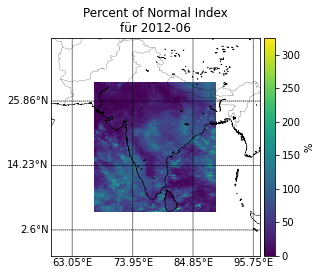

In [32]:
# temporäre Liste um geschachtelten percent_of_average_precip_stack in xarray zu überführen
temp_1d_list = []

for months in percent_of_average_precip_stack:
    for year in months:
        temp_1d_list.append(year)
        print(year)

# Verbinden entlang der Zeitachse
PNI_1d_stack = xr.concat(temp_1d_list, 'time' )

# Aus dem neuen xarray kann nun der ermittelte Minimalwert einfach abgefragt werden
global_minimum = PNI_1d_stack.sel(time= ( PNI_1d_stack.time == maximum_dry_spell ) )

plot_aoi(global_minimum[0], "Percent of Normal Index\nfür", "%") # idx 0 entspricht dem ersten (und einzigem) Zeitpunkt des xarrays

## Falls noch Zweifel bestehen:

Text(0, 0.5, 'Häufigkeit')

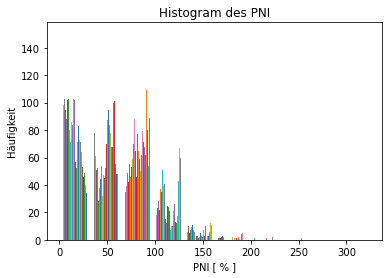

In [33]:
# Die Verteilung wird im Histogramm klarer
plt.hist( global_minimum[0] )
plt.title('Histogram des PNI')
plt.xlabel('PNI [ % ]')
plt.ylabel('Häufigkeit')